In [1]:
# Figure S7

In [2]:
import re 
import warnings

import xarray as xr
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import regionmask 

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Load sensitivity simulations

variable = "SpeciesConc_O3"

year = 2000
simulation = "w10_ref_c48_noCO2effect"
simulation_SNOx = "w10_refSNOx_c48_noCO2effect"
refCO2 = tools.get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1e9, resolution='c48')

year = 2080
simulation = "w10_refshort_c48_noCO2effect"
simulation_SNOx = "w10_refSNOxshort_c48_noCO2effect"
refshortCO2 = tools.get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1e9, resolution='c48')

In [4]:
# Load original simulations
ref = tools.get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
refshort = tools.get_original_values_diff(variable, "all_refshort_c48", "all_refSNOxshort_c48", conversion_factor=1e9, resolution='c48')
polshort = tools.get_original_values_diff(variable, "all_polshort_c48", "all_polSNOxshort_c48", conversion_factor=1e9, resolution='c48')

In [5]:
print(ref.mean().values)
print(refCO2.mean().values)
print(refshort.mean().values)
print(refshortCO2.mean().values)

-0.6118259227223248
-0.6034807324998701
-0.5657270121065859
-0.6002698400201348


In [6]:
# Store regional mean and stdev in "results"

datasets = {
    "ref": {
        "data": ref,
        "resolution": "c48"
    },
    "refCO2": {
        "data": refCO2,
        "resolution": "c48"
    },
    "refshort": {
        "data": refshort,
        "resolution": "c48"
    },
    "refshortCO2": {
        "data": refshortCO2,
        "resolution": "c48"   
    },
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  
        results[ds_name][result_key] = tools.calculate_regional_mean_std(
                ds_data, comparison_months, region
            )

In [7]:
# Define helper functions to access results
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [8]:
# Part 1: Regional Mean Ozone Response Comparison: baseline vs noCO2effect
ref_mean        = extract_means("ref")
refshort_mean   = extract_means("refshort")

refCO2_mean  = extract_means("refCO2")
refshortCO2_mean  = extract_means("refshortCO2")

ref_std        = extract_stds("ref")
refshort_std   = extract_stds("refshort")

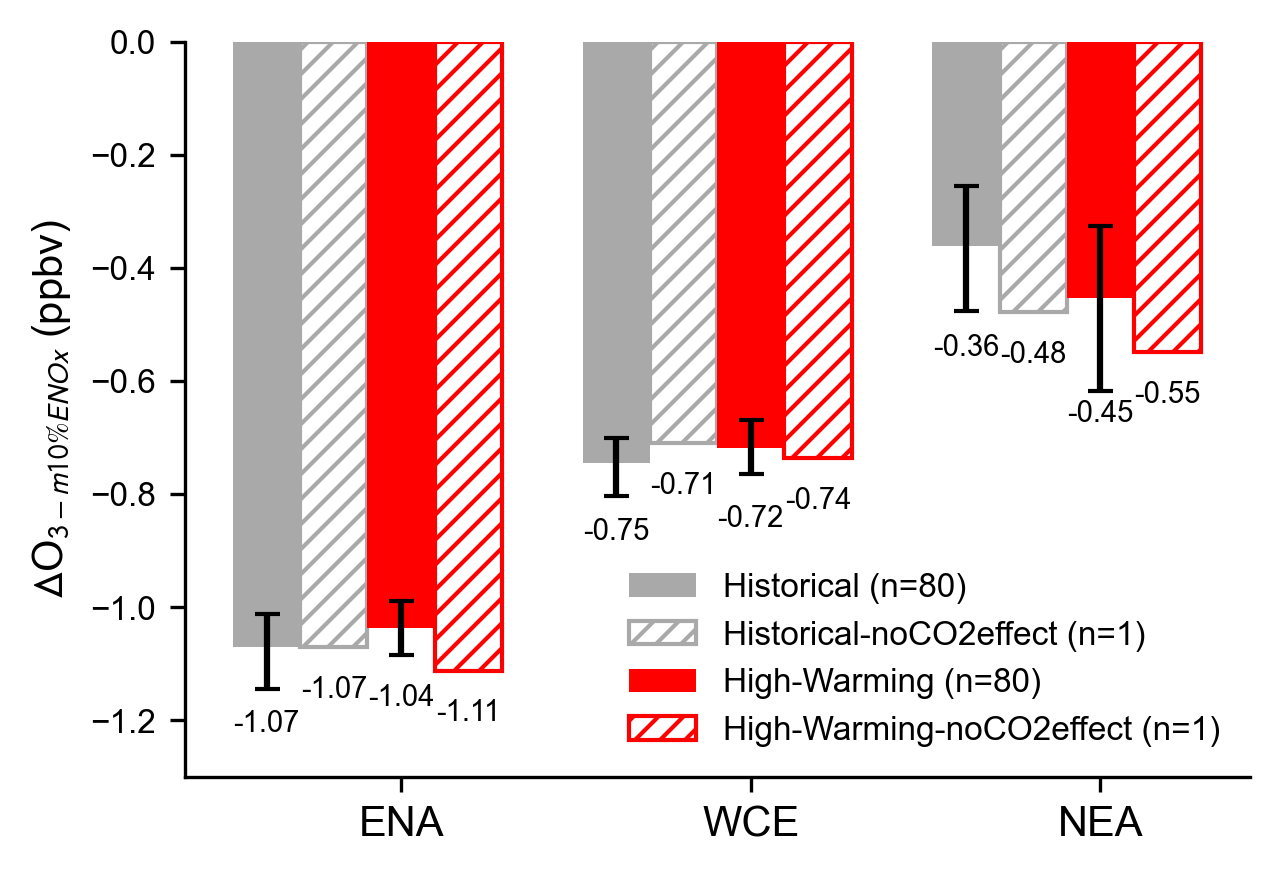

In [9]:
bar_width = 0.25
categories = ['ENA', 'WCE', 'NEA']
x = 1.3*np.arange(len(categories))

tools.set_matplotlib_font("Arial")
mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 10, 
    'axes.titlesize': 10, 
    'axes.labelsize': 10,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})


fig = plt.figure(figsize=(4.33, 2.85), dpi=300)
gs1 = GridSpec(1, 1, top=0.95, bottom=0.09, left=0.15, right=0.97, hspace=0.50, wspace=0.4)
axes = fig.add_subplot(gs1[0, 0])

axes.bar(x - 2*bar_width, ref_mean,         bar_width, yerr=tools.reshape_data(ref_std),      capsize=3, label="Historical (n=80)", color="darkgray", lw=0.5)
axes.bar(x - bar_width,   refCO2_mean,      bar_width, label="Historical-noCO2effect (n=1)", color="white", hatch='////', edgecolor="darkgray")
axes.bar(x,   refshort_mean,    bar_width, yerr=tools.reshape_data(refshort_std), capsize=3, label="High-Warming (n=80)", color="red")
axes.bar(x + bar_width, refshortCO2_mean, bar_width, label="High-Warming-noCO2effect (n=1)", color="white", hatch='////', edgecolor="red")

# Print values for each bar
for i in range(len(categories)):
    # Historical
    y_val = float(ref_mean[i].item()) - float(ref_std[i][1].item()) - 0.05
    axes.text(x[i] - 2*bar_width, y_val, f"{float(ref_mean[i]):.2f}", ha='center', va='top', fontsize=7)

    # Historical (single-member)
    y_val = float(refCO2_mean[i].item()) - 0.05
    axes.text(x[i] - bar_width, y_val, f"{float(refCO2_mean[i]):.2f}", ha='center', va='top', fontsize=7)

    # High-Warming (multi-member)
    y_val = float(refshort_mean[i].item()) - float(refshort_std[i][1].item()) - 0.05
    axes.text(x[i], y_val, f"{float(refshort_mean[i]):.2f}", ha='center', va='top', fontsize=7)

    # High-Warming (single-member)
    y_val = float(refshortCO2_mean[i].item()) - 0.05
    axes.text(x[i] + bar_width, y_val, f"{float(refshortCO2_mean[i]):.2f}", ha='center', va='top', fontsize=7)


axes.set_ylabel(r"$\Delta$O$_{3-m10\%ENOx}$ (ppbv)", fontsize=10)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(fontsize=8, frameon=False)

plt.xticks(x, categories, fontsize=10)
plt.ylim([-1.3, 0])
plt.savefig("FigS7_new.png")